#### Example IRIS code 

This example code computes the WSS for SWORD reach 22791100061 in the same way it is computed for the ICESat-2 River Surface Slope (IRIS)dataset.  
The method is described in detail in https://doi.org/10.1029/2022WR032842.

The input data for IRIS are:
- ATL13: ATLAS/ICESat-2 L3A Along Track Inland Surface Water Data (*Jasinski et al. 2021*)
- SWORD: SWOT Mission River Database (*Altenau et al. 2021*).

##### References
Altenau, E. H. et al. SWOT River Database (SWORD) (Version v1), https://doi.org/10.5281/zenodo.4917236 (2021).  
Jasinski, M. et al. ATLAS/ICESat-2 L3A Inland Water Surface Height, Version 5., https://doi.org/10.5067/ATLAS/ATL13.005 (2021).  

IRIS data is calculated on reach scale using functions of the custom SWORD_Reach class.  
Objects of the SWORD_Reach class are a python representation of the SWORD reach netcdf data provided by Altenau et al. (2021).  
Note, that all of the functions below are part of the SWORD_Reach class and are only shown for clarity and possible alternation.

In [1]:
from dgfi_if import SWORD_Reach, Conversions, Utilities
from tqdm.auto import tqdm
import pandas as pd
tqdm.pandas()
from shapely.geometry import Polygon, LineString
from shapely.ops import unary_union, nearest_points
import pickle

/DGFI15/home/scherer/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


The IRIS code expects the ATL13 data to be in the DGFI-TUM's internal MVA format.  
Since the MVA database can not be shared, this example script includes a SWORD_Reach object (**r**) for SWORD reach 22791100061 which already includes all the ATL13 data extracted from the MVA database.

In [21]:
r = pickle.load(open('./22791100061.pickle','rb')) # load the object for SWORD reach 22791100061

One of the many SWORD_Reach functions is ***get_aoi*** which buffers the reach's centerline by its average width to construct a polygon that defines the area of interest (AOI):

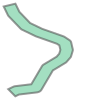

In [38]:
def get_aoi(self,buffersize=None, std_multiplicator = 1):
    """ get a coarse aoi of the reach buffered by the given parameter or the width plus four times the width standard deviation"""
    if buffersize is None:
        buffersize = self.width + std_multiplicator * self.width_std
       
    centerline_wgs84 = LineString(self.coords[1:-1])
    epsg_utm = Conversions.convert_wgs_to_utm_zone(geometry=centerline_wgs84)
    centerline_utm = Conversions.convert_wgs_geometry_to_utm(centerline_wgs84,epsg_utm)

    centerline_utm = centerline_utm.simplify(tolerance=100)
    aoi_utm = centerline_utm.buffer(buffersize, cap_style=2)
    aoi_wgs84 = Conversions.convert_utm_geometry_to_wgs(aoi_utm, epsg_utm)
    if aoi_wgs84.geom_type != 'Polygon':
        aoi_wgs84 = aoi_wgs84.convex_hull
    return list(aoi_wgs84.exterior.coords)
r.aoi = get_aoi(r, std_multiplicator=0) # For IRIS v1 the std_multiplicator is set to 0
Polygon(r.aoi)

The ATL13 data from MVA is stored in the attribute *features_by_mission*.  
Each feature contains parts of the ATL13 data from a specific beam and day intersecting the reach AOI stored as a pandas DataFrame.  
Below, the ATL13 data of the first feature is shown:

In [27]:
r.features_by_mission['icesat2_gt1l_atl13v5_hf'][0]['data']

,lon,lat,wgs_coord,alongtrack_distance,elev,depth,atl13_slope,jday,strong,geoh07,water_body_id,water_body_type,cloud_flag_asr_atl09,cloud_flag_atm_atl09,layer_flag_atl09,qf_cloud,qf_ice,snow_ice_atl09
0,18.941152,45.631690,"(18.941152, 45.63169)",0.000000,124.902,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
1,18.941118,45.631931,"(18.941118, 45.631930999999994)",26.958228,124.910,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
2,18.941083,45.632184,"(18.941083, 45.632183999999995)",55.253504,124.885,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
3,18.941068,45.632292,"(18.941067999999998, 45.632292)",67.332574,124.844,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
4,18.941061,45.632349,"(18.941060999999998, 45.632349)",73.700747,124.816,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,18.932704,45.692577,"(18.932703999999998, 45.692577)",6809.702158,125.127,14.995,0.000660,6993.82576,None,44.772,2006069,5,1,1,0,NaN,NaN,1
466,18.932696,45.692634,"(18.932696, 45.692634)",6816.077786,125.133,14.995,0.000660,6993.82576,None,44.772,2006069,5,1,1,0,NaN,NaN,1
467,18.932688,45.692698,"(18.932688, 45.692698)",6823.229007,125.149,14.995,0.000660,6993.82576,None,44.772,2006069,5,1,1,0,NaN,NaN,1
468,18.932681,45.692749,"(18.932681, 45.692749)",6828.932330,125.168,14.995,0.000660,6993.82576,None,44.772,2006069,5,1,1,0,NaN,NaN,1


Now, we iterate over all features and apply the function *icesat2_pass_helper*:

In [ ]:
def icesat2_pass_helper(self, feature : Dict, max_median_deviation : float = 0.05, min_size_to_apply_window : int = 20, window_size : int = 7, max_slope : float = 0.0003, debug : Union[bool,str]= False):
    """Helper Function to reject outliers and convert along track slope to along centerline slope"""
    pass_geom = wkt.loads(feature['geometry'])
    centerline = LineString(self.coords)

    #######################################################################################
    ### First Intersection for splitting features if necessary
    intersection = pass_geom.intersection(centerline)
    if intersection.is_empty:
        nearest = nearest_points(pass_geom, centerline)
        ref_point_lon = nearest[0].x
        ref_point_lat = nearest[0].y
    elif intersection.geom_type == 'Point':
        ref_point_lon = intersection.x
        ref_point_lat = intersection.y
    elif intersection.geom_type == 'MultiPoint':
        distances = {}
        for i, point in enumerate(intersection.geoms):
            distances[i] = feature['data'].apply(lambda x: Utilities.openadb_spherical_distance(point.x,point.y,x.lon,x.lat),axis=1)
        df = pd.DataFrame(distances)
        nearest_point = df.idxmin(axis=1)
        data = []
        for i in distances.keys():
            this_index = nearest_point[nearest_point == i]
            new_feature = deepcopy(feature)
            new_feature['data'] = new_feature['data'][new_feature['data'].index.isin(this_index.index)]
            if len(new_feature['data'].lon) < 2:
                continue
            try:
                new_feature['geometry'] = Utilities.linestring_helper(new_feature['data'].lon, new_feature['data'].lat)
                _data = self.icesat2_pass_helper(feature=new_feature,max_median_deviation=max_median_deviation,min_size_to_apply_window=min_size_to_apply_window,window_size=window_size,debug=debug)
            except Utilities.MiscException as e:
                _data = None
            except SWORDException as e:
                _data = None
            if _data is not None:
                data.append(_data)
        return data
    #######################################################################################

    atl13_pass_data = feature['data']
    epsg_utm = Utilities.convert_wgs_to_utm_zone(lon=ref_point_lon, lat=ref_point_lat)
    ydata = atl13_pass_data.elev - atl13_pass_data.geoh07
    xdata = atl13_pass_data.alongtrack_distance

    #######################################################################################
    ### Outlier Detection

    if ydata.shape[0] > min_size_to_apply_window:
        window_median = ydata.rolling(window_size,min_periods=int(np.floor(window_size/2)),center=True).median()
        median_flags = (window_median - ydata).abs() <= max_median_deviation # False : AMD Outlier
    else:
        median_flags = (ydata - ydata.median()) <= max_median_deviation # False : AMD Outlier
    
    type_flags = True #atl13_pass_data.water_body_type.isin([2,5,6]) # Allowed Values: Reservoir, River, Estuary -> False : Type Outlier
    cloud_flags = atl13_pass_data.cloud_flag_asr_atl09.isin([0,1,2,3]) # -> False: Cloud Outlier
    ice_flags = atl13_pass_data.snow_ice_atl09.isin([0,1]) # -> False: Ice Outlier
    flags = type_flags & median_flags & cloud_flags & ice_flags # False : Type, Cloud, Ice, and AMD Outlier
    
    atl13_pass_data.loc[:,"type_flag"] = type_flags
    atl13_pass_data.loc[:,"median_flag"] = median_flags
    atl13_pass_data.loc[:,"cloud_flag"] = cloud_flags
    atl13_pass_data.loc[:,"ice_flags"] = ice_flags
    
    xdata_ice_outlier = xdata.loc[~ice_flags]
    ydata_ice_outlier = ydata.loc[~ice_flags]

    amd_xdata_outlier = xdata.loc[~flags] # For Debug Plot
    amd_ydata_outlier = ydata.loc[~flags] # For Debug Plot
    xdata = xdata.loc[flags]
    ydata = ydata.loc[flags]
    
    if xdata.shape[0] < 2:
        logger.debug('No Data after AMD and Type Outlier removal')
        return None
    
    clusters = (xdata.diff() > 500).cumsum()
    cluster_flags = clusters == clusters.value_counts().idxmax() # False: Cluster Outlier (Only longest Cluster is used)

    cluster_xdata_outlier = xdata.loc[~cluster_flags] # For Debug Plot
    cluster_ydata_outlier = ydata.loc[~cluster_flags] # For Debug Plot
    xdata = xdata.loc[cluster_flags]
    ydata = ydata.loc[cluster_flags]

    atl13_pass_data.loc[:,"cluster_flag"] = atl13_pass_data.index.isin(xdata.index) #cluster_flags

    if xdata.shape[0] < 2:
        logger.debug('No Data after Cluster Outlier removal')
        return None

    #######################################################################################
    ###  Position and Angle Determination
    pass_geom = Utilities.validate_geometry(LineString(atl13_pass_data[atl13_pass_data.cluster_flag.fillna(False)].wgs_coord.to_list()))
    intersection = pass_geom.intersection(centerline)
    if intersection.is_empty:
        nearest = nearest_points(pass_geom, centerline)
        ref_point_lon = nearest[0].x
        ref_point_lat = nearest[0].y
    elif intersection.geom_type == 'Point':
        ref_point_lon = intersection.x
        ref_point_lat = intersection.y
    elif intersection.geom_type == 'MultiPoint':
        raise SWORDException('Feature should be split')
    atl13_pass_data.loc[:,'ref_distance'] = Utilities.great_circle_dist(atl13_pass_data.lon.to_numpy(), atl13_pass_data.lat.to_numpy(), ref_point_lon, ref_point_lat) * 1000
    x0 = atl13_pass_data.alongtrack_distance.loc[atl13_pass_data.ref_distance.idxmin()]
    postion = self.get_reach_position_of_closest_cl_point(ref_point_lon, ref_point_lat)
    node_id = self.search_reach_id(lon=ref_point_lon, lat=ref_point_lat, return_node=True)
    normal = self.get_node_normal(node_id, pointing='straight')
    normal_utm = Utilities.convert_wgs_geometry_to_utm(normal, epsg_utm)
    normal_coords = np.asarray(Utilities.get_geom_coordinates(normal_utm))
    pass_geom_utm = Utilities.convert_wgs_geometry_to_utm(pass_geom, epsg_utm)
    pass_coords = np.asarray(Utilities.get_geom_coordinates(pass_geom_utm))
    
    normal_vector = normal_coords[-1] - normal_coords[0]
    pass_vector = pass_coords[-1] - pass_coords[0]
    u, v = pass_vector, normal_vector
    u_norm = np.sqrt(sum(u*u))
    v_norm = np.sqrt(sum(v*v))
    dot = np.dot(u, v)

    #######################################################################################
    ### This Block handles pass height estmate using SVR based on DAHITI approach and SVR outlier rejection
    limit = ((xdata.max() - xdata.min()) * max_slope) / 2
    limit = .05
    distances = np.abs(xdata - x0)
    distance_weights = 1./np.where(distances==0,1,distances)
    xscaler = StandardScaler() # SVR works better when data is scaled
    yscaler = StandardScaler()
    xscaler.fit(xdata.to_numpy().reshape(-1, 1))
    yscaler.fit(ydata.to_numpy().reshape(-1, 1))
    xscaled = xscaler.transform(xdata.to_numpy().reshape(-1, 1))
    yscaled = yscaler.transform(ydata.to_numpy().reshape(-1, 1))
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',message='Liblinear failed to converge, increase the number of iterations.')
        svr = LinearSVR(random_state=0,max_iter=1e6)
        svr.fit(xscaled,np.ravel(yscaled),sample_weight=distance_weights)
    y_predict = yscaler.inverse_transform(svr.predict(xscaled))
    y_deviation = (ydata - y_predict).abs()
    svr_flags = y_deviation <= limit
    y_predict = y_predict[svr_flags]
    if y_predict.size > 0:
        # svr_elev = np.nanmean(y_predict)
        # distances = distances[svr_flags]
        svr_elev = np.average(ydata[svr_flags],weights=distance_weights[svr_flags])
        median_elev = np.median(ydata)
    else:
        svr_elev = np.nan
        median_elev = np.nan

    svr_xdata_outlier = xdata.loc[~svr_flags] # For Debug Plot
    svr_ydata_outlier = ydata.loc[~svr_flags] # For Debug Plot
    xdata = xdata[svr_flags]
    ydata = ydata[svr_flags]
    width = np.max(xdata) - np.min(xdata)
    atl13_pass_data.loc[:,'svr_flag'] = atl13_pass_data.index.isin(xdata.index)
    atl13_pass_data.loc[:,'rejected'] = ~(atl13_pass_data.svr_flag & atl13_pass_data.cluster_flag & atl13_pass_data.median_flag & atl13_pass_data.type_flag)

    if xdata.shape[0] < 2:
        if debug:
            logger.debug('No Data after SVR Outlier removal')
        return None

    #######################################################################################
    ### This Block handles the conversion from atl13 along track slope to along river centerline slope
    dot_crossing_angle_deg = np.rad2deg(np.arccos(dot/(u_norm * v_norm)))
    if dot != 0 and xdata.size > 1: # orthogonal flying
        tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
        ts = tinv(0.05, len(xdata)-2)
        slope, intercept, r, p, se = stats.linregress(xdata, ydata)
        slope_confidence = ts*se 
        dh = -1 * (u_norm * slope)
        proj_of_u_on_v = (dot/v_norm**2)*v
        l = np.sqrt(sum(proj_of_u_on_v**2))
        adjusted_custom_along_track_slope = (dh/l) * np.sign(dot)
    else:
        adjusted_custom_along_track_slope = np.nan
        slope, intercept, r, p, se = np.nan,np.nan,np.nan,np.nan,np.nan
        slope_confidence = np.nan
    
    #######################################################################################

    date_object = julianDayDate(np.nanmean(atl13_pass_data.jday))
    date = datetime.datetime(year=date_object["year"], month=date_object["month"], day=date_object["day"], hour=date_object["hour"], minute=date_object["minute"])

    if debug is True or debug == date.strftime('%Y-%m-%d'):
        plt.rc('font', size=14)  
        fig, ax = plt.subplots(figsize=(20,10))
        plt.sca(ax)
        cloud_flag_asr_atl09 = atl13_pass_data[atl13_pass_data.svr_flag].cloud_flag_asr_atl09.to_numpy()
        sc = plt.scatter(xdata, ydata, c=cloud_flag_asr_atl09, label='Valid ATL13 Observations', cmap=matplotlib.colors.ListedColormap([tum.blue,tum.light_blue2,tum.light_blue,tum.light_grey,tum.dark_grey,tum.orange]), vmax=6)
        ylim = list(plt.ylim())
        xlim = list(plt.xlim())
        plt.plot(amd_xdata_outlier, amd_ydata_outlier, '.',color=tum.grey, label='Type, Cloud, or AMD Outlier')
        plt.plot(svr_xdata_outlier, svr_ydata_outlier, '+',color=tum.grey, label='SVR Outlier')
        plt.plot(cluster_xdata_outlier, cluster_ydata_outlier, 'x',color=tum.grey, label='Cluster Outlier')
        plt.plot(xdata_ice_outlier, ydata_ice_outlier, '.',color='red', label='ICE Outlier')
        # plt.colorbar(sc)
        plt.plot(xdata, intercept + slope*xdata, color=tum.orange, label='Slope Fit')
        # plt.plot(xdata,y_predict,'b--',label="SVR fit")
        if svr_elev is not None:
            plt.axhline(svr_elev, label='Reference Point/Elevation',color=tum.grey)
        else:
            plt.axhline(median_elev, label='Median Height', linestyle='--')
        plt.axvline(x0,color=tum.grey)
        plt.xlabel('Along Track Distance [m]')
        plt.ylabel('Elevation [m]')
        date_str = date.strftime("%Y-%m-%d")
        plt.title(f'Reach {self.reach_id} Date {date_str} Beam {feature["beam"]}\nCrossing Angle: {dot_crossing_angle_deg:.2f} Along Track Slope: {adjusted_custom_along_track_slope*1e6:.0f} +- {slope_confidence*1e6:.0f} mm/km')
        quantiles = (atl13_pass_data.elev - atl13_pass_data.geoh07).quantile([0.1,0.99]).to_list()
        if ylim[0] > quantiles[0]:
            ylim[0] = quantiles[0]
        if ylim[1] < quantiles[1]:
            ylim[1] = quantiles[1]
        plt.ylim(ylim)
        # plt.xlim(xlim)
        plt.legend(loc='upper left')
        plt.show()
        plt.close()
        _df = gpd.GeoDataFrame(atl13_pass_data,geometry=atl13_pass_data.wgs_coord.apply(Point))
        _df = _df.set_crs(epsg=4326)
        _df = _df.to_crs(epsg=3857)
        _centerline = gpd.GeoSeries(centerline)
        _centerline = _centerline.set_crs(epsg=4326)
        _centerline = _centerline.to_crs(epsg=3857)
        ax = _df[~_df.rejected].plot(figsize=(6, 6),color=tum.light_blue2, label="Valid ATL13 Observations")
        _centerline.plot(ax=ax,linewidth=2, label="centerline",color=tum.orange)

        _aoi = gpd.GeoSeries(Polygon(self.aoi))
        _aoi = _aoi.set_crs(epsg=4326)
        _aoi = _aoi.to_crs(epsg=3857)
        _aoi.plot(ax=ax,linewidth=2, label="centerline",color=tum.blue,alpha=0.5)

        # ax.axis('equal')
        ymin, ymax = plt.ylim()
        xmin, xmax = plt.xlim()
        xamp = xmax - xmin
        yamp = ymax - ymin
        buffer = np.abs((xamp - yamp) / 2.)
        if xamp > yamp:
            ymax += buffer
            ymin -= buffer
        else:
            xmax += buffer
            xmin -= buffer

        bounds = gpd.GeoSeries(box(xmin,ymin,xmax,ymax)).set_crs(3857)
        bounds.plot(ax=ax,facecolor="none",edgecolor="none")
        bounds = bounds.to_crs(4326).iloc[0]
        # plt.ylim(np.array(plt.ylim()) + np.array([-1e4,1e4]))
        # plt.xlim(np.array(plt.xlim()) + np.array([-1e4,1e4]))
        try:
            # cx.add_basemap(ax, crs=_df.crs, source=cx.providers.Esri.WorldImagery)
            from .import EE_IF
            ee = EE_IF()
            url = ee.get_s2_mosaic_url(date=date,poi=bounds,daysdelta=21)
            cx.add_basemap(ax, crs=_df.crs, source=url)
        except:
            ...
        ax.add_artist(ScaleBar(2,location="lower right"))
        plt.legend()
        plt.xticks([], [])
        plt.yticks([], [])
        plt.show()
        plt.close()
            
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore')
        return {
            'date': date.date(),
            'timestamp': date,
            'mission': feature['mission'],
            'position': postion,
            'lon': ref_point_lon,
            'lat': ref_point_lat,
            'median_elev': median_elev,
            'svr_elev' : svr_elev,
            'elev' : svr_elev if svr_elev is not None else median_elev,
            'elev_std': atl13_pass_data.elev[~atl13_pass_data.rejected].std(),
            'atl13_slope': atl13_pass_data.atl13_slope[~atl13_pass_data.rejected].median(),
            'min_depth': atl13_pass_data.depth[~atl13_pass_data.rejected].min(),
            'max_depth': atl13_pass_data.depth[~atl13_pass_data.rejected].max(),
            'median_depth': atl13_pass_data.depth[~atl13_pass_data.rejected].median(),
            'water_body_ids' : atl13_pass_data.water_body_id[~atl13_pass_data.rejected].unique(),
            'water_body_types' : atl13_pass_data.water_body_type[~atl13_pass_data.rejected].unique(),
            'hf_data': atl13_pass_data,
            'custom_along_track_slope' : slope,
            'custom_along_track_slope_err': se,
            'custom_along_track_slope_abs_rvalue': np.abs(r),
            'custom_along_track_slope_pvalue': p,
            'adjusted_custom_along_track_slope' : adjusted_custom_along_track_slope,
            'dot_crossing_angle_deg' : dot_crossing_angle_deg,
            'node_id' : node_id,
            'width' : width,
            'slope_confidence': slope_confidence,
            }

icesat2_data = []
def rec_append(input):
    # Helper Function for nested data
    if isinstance(input,list):
        for item in input:
            rec_append(item)
    else:
        icesat2_data.append(input)

for features in tqdm(list(r.features_by_mission.values()), desc=f'Estimating ICESat-2 Heights and Along Slope for Reach {r.reach_id} by beam', leave=False):
    for feature in features:
        if feature['data'].empty:
            continue
        data = r.icesat2_pass_helper(feature)
        if data is None:
            continue
        if isinstance(data, list):
            rec_append(data)
        else:
            icesat2_data.append(data)
r.icesat2_data = pd.DataFrame(icesat2_data)